# Анализ бизнес-показателей. Проект.

## Предобработка данных

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [2]:
# забираю таблицы
try:
    visits, orders, costs = (
        pd.read_csv('/datasets/visits_info_short.csv'),
        pd.read_csv('/datasets/orders_info_short.csv'),
        pd.read_csv('/datasets/costs_info_short.csv')
)
except:
        visits, orders, costs = (
        pd.read_csv('visits_info_short.csv'),
        pd.read_csv('orders_info_short.csv'),
        pd.read_csv('costs_info_short.csv')
)

In [3]:
# привожу к нормальному виду названия столбцов и преобразую данные о времени
visits.columns = visits.columns.str.lower().str.replace(' ', '_')
orders.columns = orders.columns.str.lower().str.replace(' ', '_')
costs.columns = costs.columns.str.lower()

visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [4]:
# проверяю таблицы на дубликаты
print(
    visits.duplicated().sum(),
    orders.duplicated().sum(),
    costs.duplicated().sum()
)

0 0 0


## Функции для расчета и анализа LTV, ROI, удержания и конверсии

### Функция для создания пользовательских профилей

In [5]:
# функция для создания пользовательских профилей
def get_profiles(sessions, orders, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

### Функция для расчёта удержания

In [6]:
# функция для расчёта удержания
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

### Функция для расчёта конверсии

In [7]:
# функция для расчёта конверсии
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

### Функция для расчёта LTV и ROI

In [8]:
# функция для расчёта LTV и ROI
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

### Функция для сглаживания фрейма

In [9]:
# функция для сглаживания фрейма
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [10]:
# функция для визуализации удержания
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

### Функция для визуализации конверсии

In [11]:
# функция для визуализации конверсии
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Функция для визуализации LTV и ROI

In [12]:
# функция для визуализации LTV и ROI
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Исследовательский анализ данных

Постройте профили пользователей. Определите минимальную и максимальную дату привлечения пользователей.

Выясните:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

In [13]:
# получаю профили пользователей
profiles = get_profiles(visits, orders, costs)

# мин, макс даты привлечен. пользоваталей
min_date = profiles['first_ts'].min()
max_date = profiles['first_ts'].max()
print('Минимальная дата привлечения пользоваталей: ', min_date)
print('Максимальная дата привлечения пользоваталей: ', max_date)

Минимальная дата привлечения пользоваталей:  2019-05-01 00:00:41
Максимальная дата привлечения пользоваталей:  2019-10-27 23:59:04


In [14]:
def report(data):
    report = profiles.groupby(data).agg({'user_id': 'nunique', 'payer': ['sum', 'mean']})
    report.columns = ['Пользователи', 'Платящие пользователи', '% платящих']
    return report

In [15]:
(report('region')
 .sort_values(by = 'Пользователи', ascending = False)
 .style.format({'Платящие пользователи': '{:.0f}', '% платящих': '{:.2%}'})
)

,Пользователи,Платящие пользователи,% платящих
region,,,
United States,100002,6902,6.90%
UK,17575,700,3.98%
France,17450,663,3.80%
Germany,14981,616,4.11%


In [16]:
(report('device')
 .sort_values(by = 'Пользователи', ascending = False)
 .style.format({'Платящие пользователи': '{:.0f}', '% платящих': '{:.2%}'})
)

,Пользователи,Платящие пользователи,% платящих
device,,,
iPhone,54479,3382,6.21%
Android,35032,2050,5.85%
PC,30455,1537,5.05%
Mac,30042,1912,6.36%


In [17]:
(report('channel')
 .sort_values(by = 'Пользователи', ascending = False).head()
 .style.format({'Платящие пользователи': '{:.0f}', '% платящих': '{:.2%}'})
)

,Пользователи,Платящие пользователи,% платящих
channel,,,
organic,56439,1160,2.06%
FaceBoom,29144,3557,12.20%
TipTop,19561,1878,9.60%
OppleCreativeMedia,8605,233,2.71%
LeapBob,8553,262,3.06%


Исходя из данных можно сделать вывод, что
1. Самая платящая срана это `United States`, там и пользователей больше всех и конверсия высокая. UK,France,Germany имеют примерно одинаковые показатели.
2. Лучшие платящие устройства это `iPhone и Mac`
3. Самый лучший платный трафик приходит с каналов `FaceBoom, AdNonSense, lambdaMediaAds`

## Маркетинг

Выясните:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

In [18]:
# выясняю общую сумму трат
costs_sum = costs['costs'].sum()
round(costs_sum, 1)

105497.3

In [19]:
# сумма трат по источникам
costs.groupby('channel')['costs'].sum().sort_values(ascending=False)

channel
TipTop                54751.30
FaceBoom              32445.60
WahooNetBanner         5151.00
AdNonSense             3911.25
OppleCreativeMedia     2151.25
RocketSuperAds         1833.00
LeapBob                1797.60
lambdaMediaAds         1557.60
MediaTornado            954.48
YRabbit                 944.22
Name: costs, dtype: float64

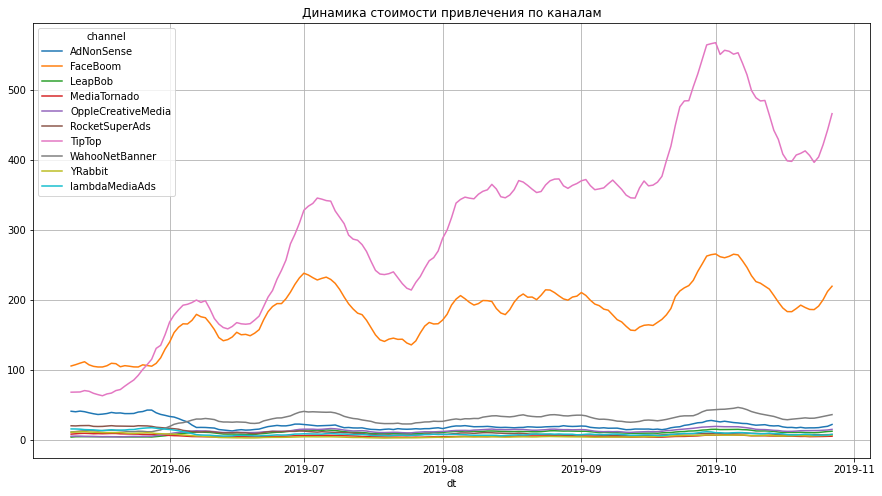

In [20]:
#создаю сводную таблицу
result = costs.pivot_table(index='dt', columns='channel', values='costs', aggfunc='sum')

# сглаживаю фрейм
filter_data(result, 10)

# строю график по динамике стоимости привлечения по каналам
result.plot(figsize=(15,8), grid=True, title='Динамика стоимости привлечения по каналам')
plt.show()

Судя по графику итоговые траты на каналы `TikTop и FaceBoom` выше в десятки раз, чем у остальных. Надо будет присмотреться к этим каналам в будущих анализах.

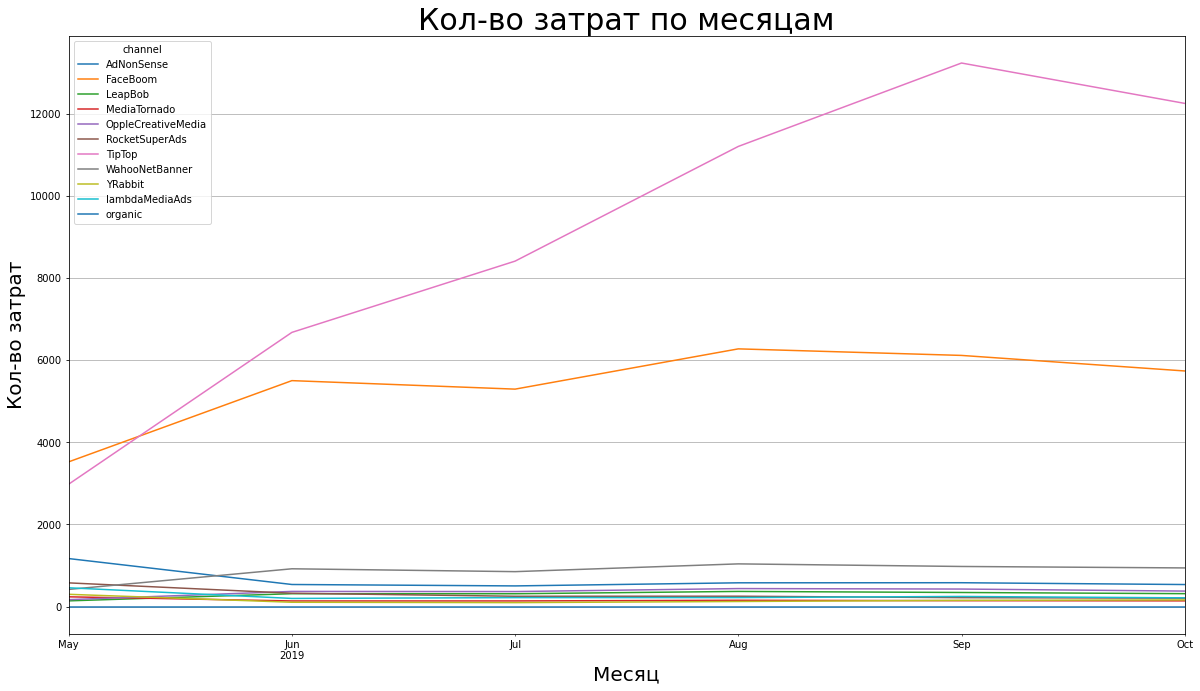

In [21]:
profiles.pivot_table(index='month', columns='channel', values='acquisition_cost', aggfunc='sum'
                                    ).plot(grid=True, figsize=(20, 11))
plt.title("Кол-во затрат по месяцам",fontsize=30)
plt.xlabel("Месяц",fontsize=20)
plt.ylabel("Кол-во затрат",fontsize=20)
plt.show();

In [22]:
# Рассчитываю средний CAC на одного пользователя
round(profiles['acquisition_cost'].mean(), 3)

0.703

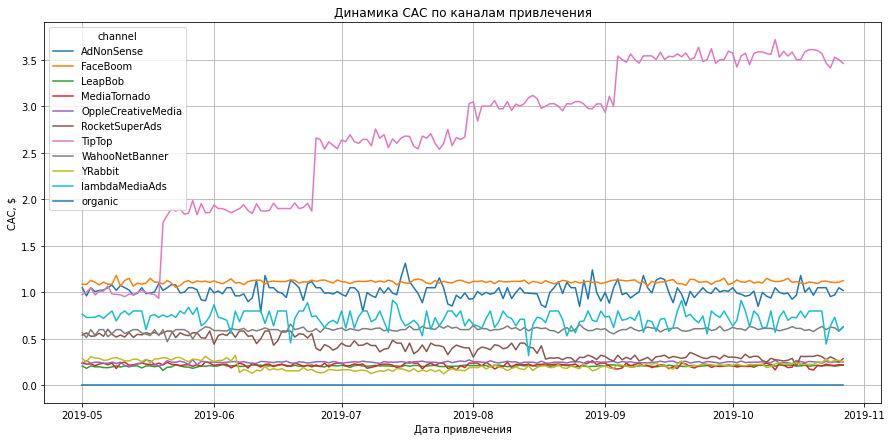

In [23]:
# строим график истории изменений CAC по каналам привлечения

profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(15, 7))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

In [24]:
# таблица значений по CAC в разрезе каналов
report = profiles.groupby('channel').agg({'acquisition_cost': 'mean'})
report.columns = ['acquisition_cost_mean']
report.sort_values(by='acquisition_cost_mean', ascending=False).style.format({'acquisition_cost_mean': '{:.2}'})

,acquisition_cost_mean
channel,
TipTop,2.8
FaceBoom,1.1
AdNonSense,1.0
lambdaMediaAds,0.72
WahooNetBanner,0.6
RocketSuperAds,0.41
OppleCreativeMedia,0.25
YRabbit,0.22
MediaTornado,0.22


В среднем у всех каналов стоимость привлечения пользователя 0.3usd - 1usd
<br>
Но вот очень выделяется канал `TipTop`. У него стоимость доходит до 3.5usd.
<br> Средняя стоимость одного пользователя по всем каналам  0.7usd (но тут мне кажется tiptop чуть повлиял).

## Оценка окупаемости рекламы для привлечения пользователей

### Анализ окупаемости рекламы

In [25]:
# задаю момент анализа и горизонт анализа
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14

In [26]:
# исключаем органику из анализа, т.к. нам нужны только платящие пользователи
profiles = profiles.query('channel != "organic"')

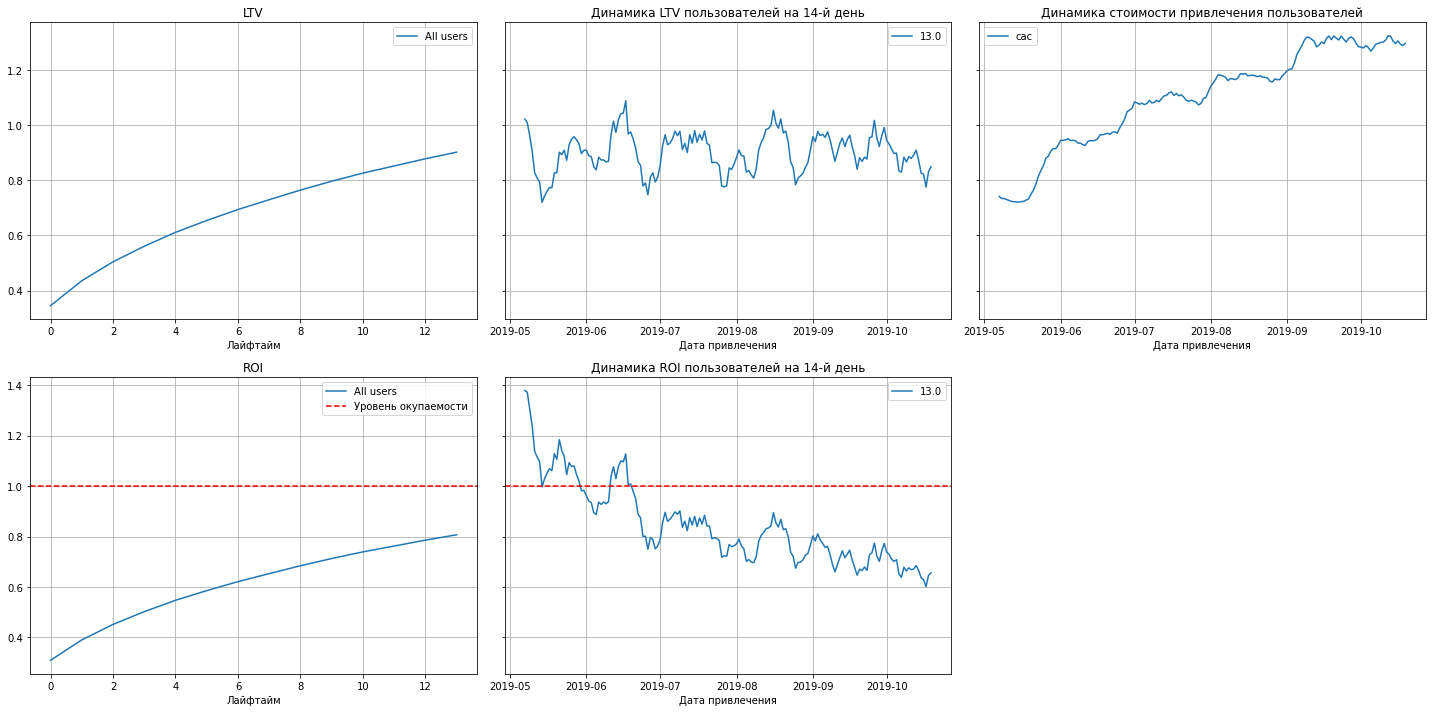

In [27]:
# считаю LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строю графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Пока можно сделать такие выводы: <br>
1. Реклама не окупается, ROI на 13 день ~80%, а нужен >100%
2. Динамика CAC растет со временем, а динамика ROI падает.
3. LTV вроде в норме.

<br> посмотрю окупаемость рекламы с разбивкой по девайсам, странам и каналам
  

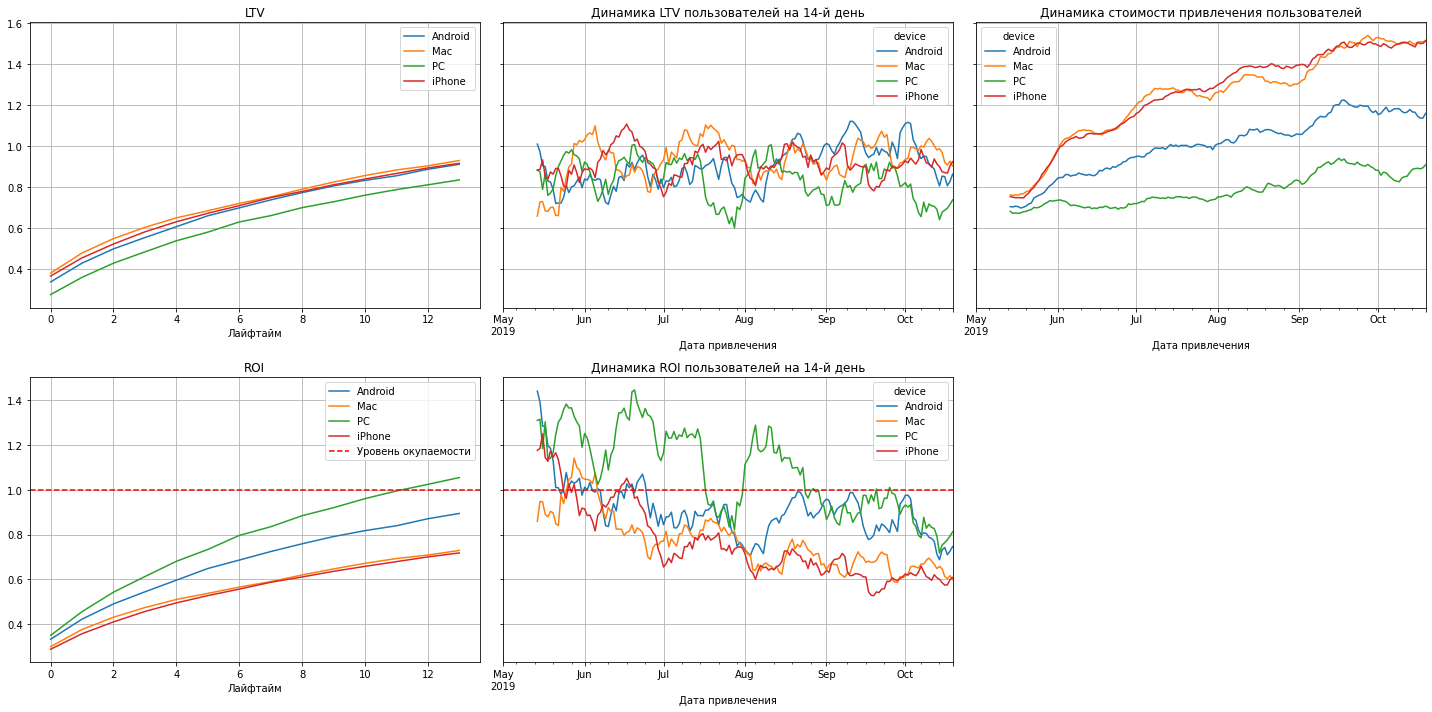

In [28]:
# анализ окупаемости рекламы с разбивкой по устройствам
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Начали очень агрессивно закупать пользователей с Мая, и там же ROI полетел вниз.
1. Реклама окупается только на девайсах `Android`
2. Самая высокая стоимость привлечения пользователей у iPhone и MAC девайсов. В середине Android, самая низкая у PC.


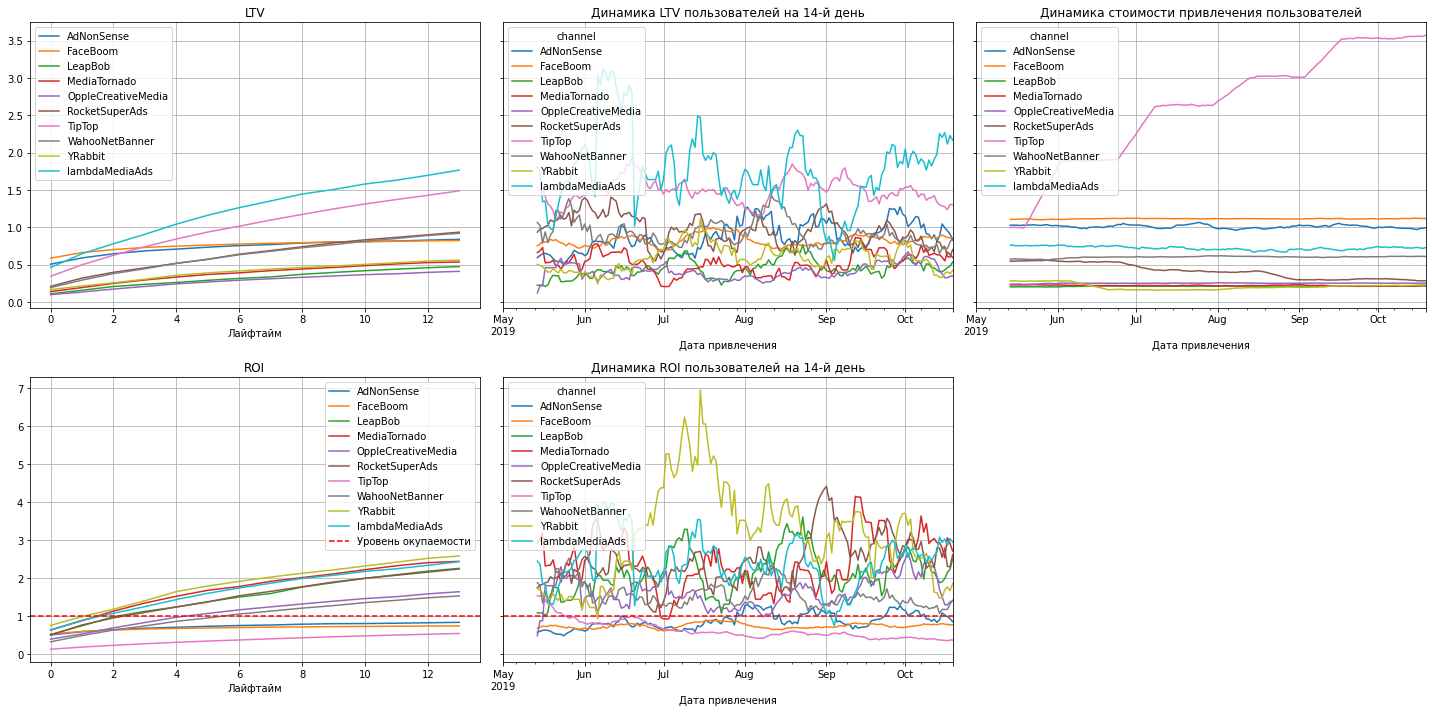

In [29]:
# анализ окупаемости рекламы с разбивкой по каналам
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

1. Каналы `TipTop, FaceBom, AdNonSense` не окупаются. По остальным вроде все хорошо.
2. У канала `TipTop` очень высокая стоимость привлечения пользователей.
3. Лучшие каналы по окупаемости `YRabbit, MediaTornado, lambdaMediaAds, RocketSuperAds.`


Если посмотреть по каналам на динамику стоимости привлечения пользователей, то сразу бросается в глаза наш "любимчик" `TipTop`. Он просто монстр по поеданию рекламного бюджета, причем закупку по этому каналу увеличивают в каждый месяц. У остальных каналов динамика стабильная, хотя на некоторые бюджет уменьшается, например на `RocketSuperAds`.

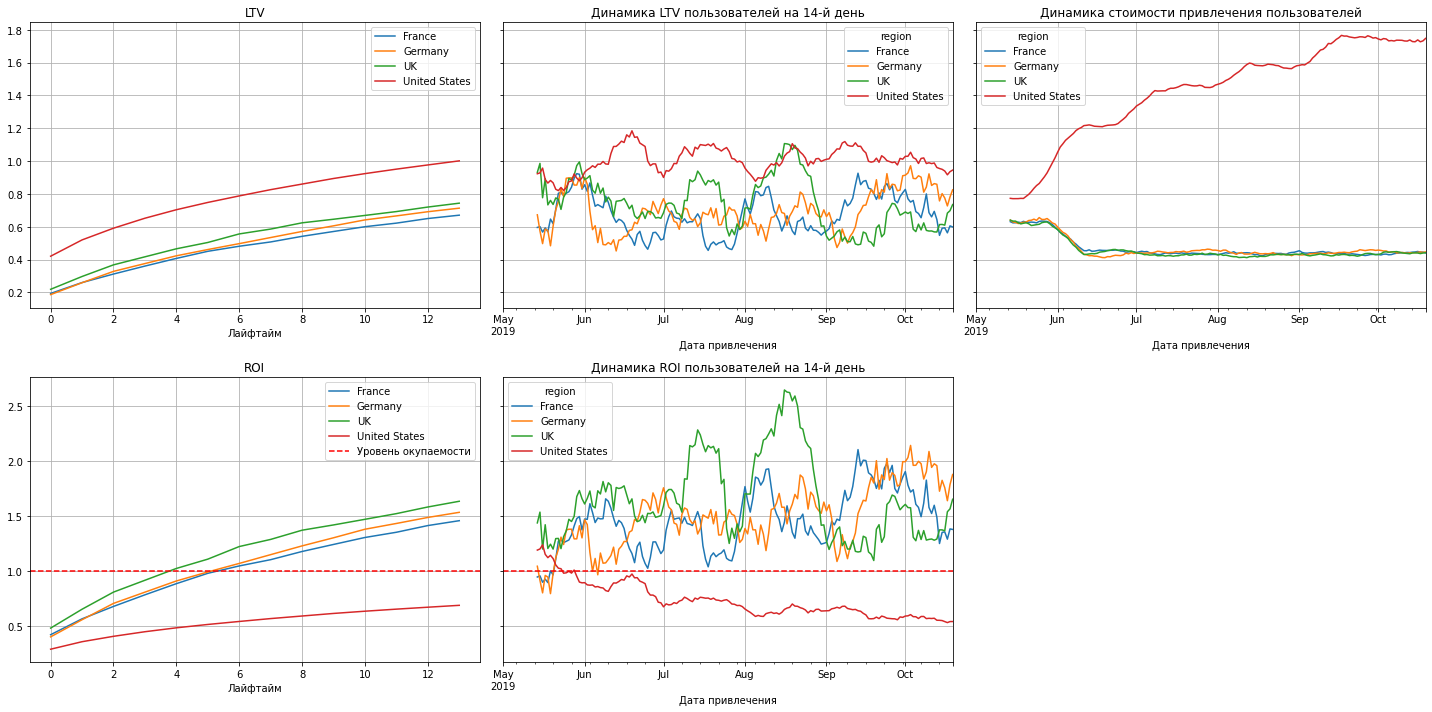

In [30]:
# анализ окупаемости рекламы с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

1. Страны `France, Germany, UK` окупаются.
2. `United States` не окупается.
3. Стоимость привлечения `United States` пользователей очень высокая (скорее всего за счет канала `TipTop`)

<br>
Проверю конверсию пользователей.

### Анализ конверсии пользователей

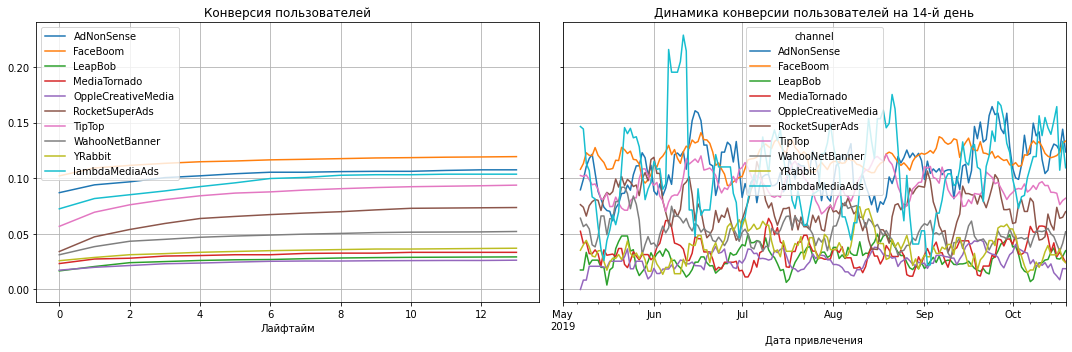

In [31]:
# анализ конверсии пользователей с разбивкой по странам
dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Лучшая конверсия с каналов `FaceBoom, AdNonSense, lambdaMediaAds, TipTop`.

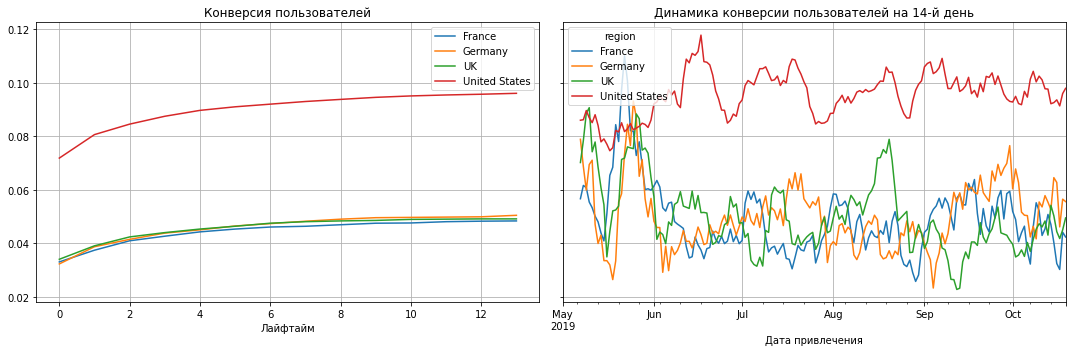

In [32]:
# анализ конверсии пользователей с разбивкой по странам
dimensions = ['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Судя по графикам, пользователи `United States` конвертируются очень хорошо, причём постоянно. Надо проверить удержание.

### Анализ удержания пользователей

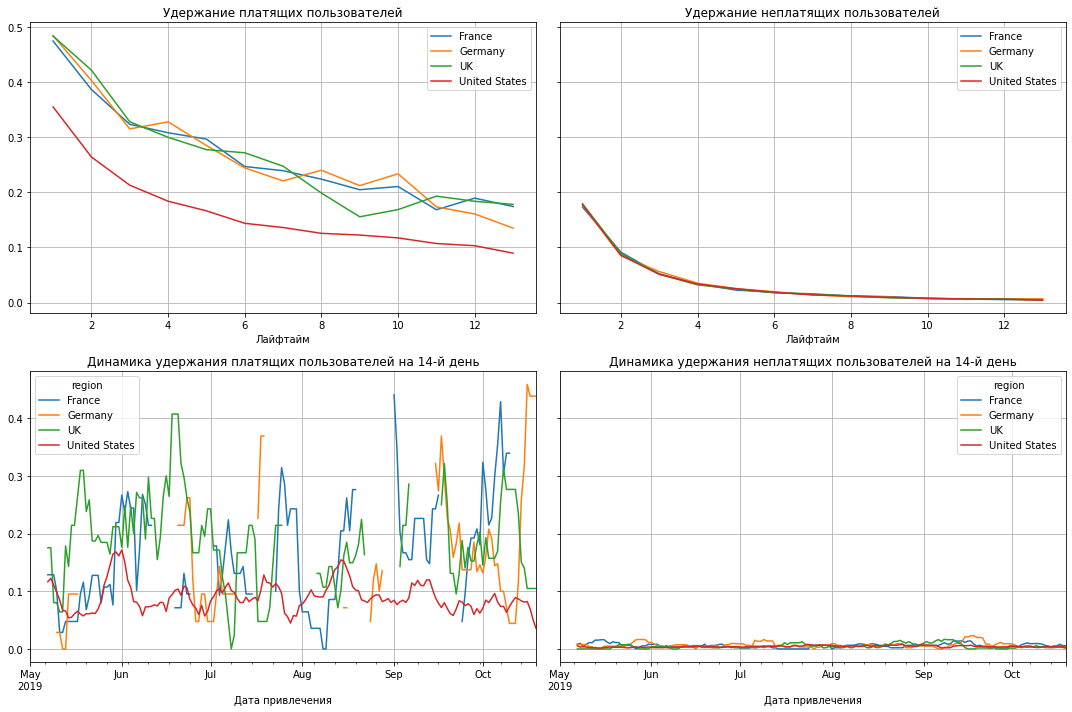

In [33]:
# смотрим удержание с разбивкой по регионам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Удержание платящих пользователей `United States` ниже, чем у остальных (хотя там самая высокая конверсия). Возможно где-то есть техническая проблема или что-то еще. Смотрим дальше.

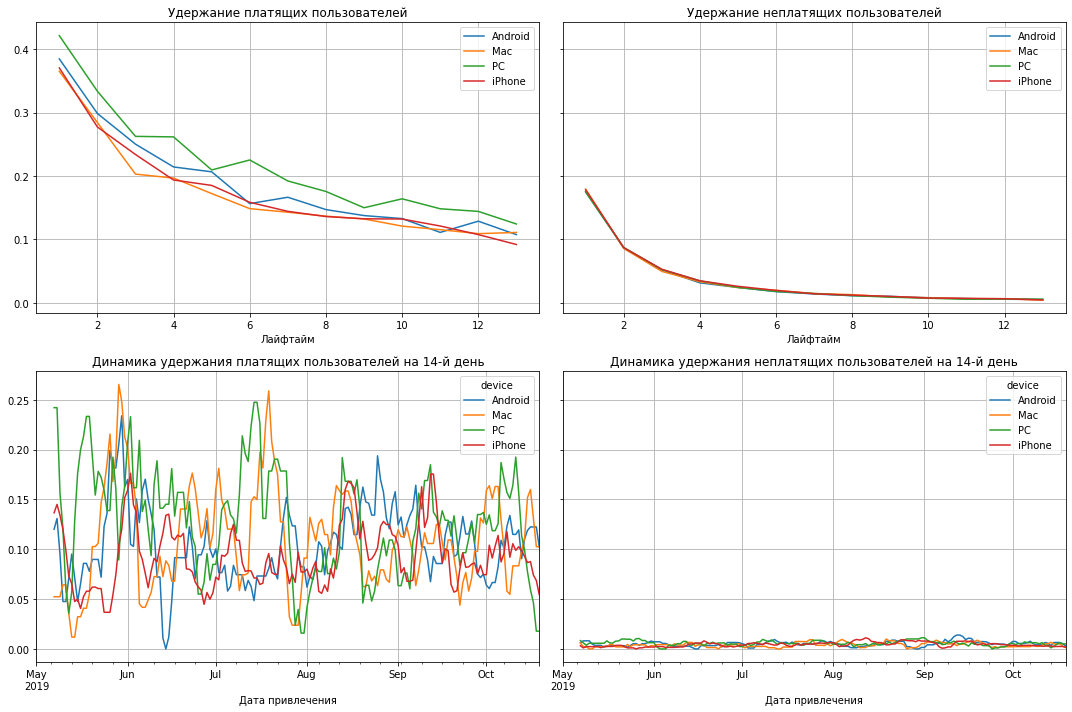

In [34]:
# смотрим удержание с разбивкой по девайсам
dimensions = ['device']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

По девайсам все более менее стабильно.

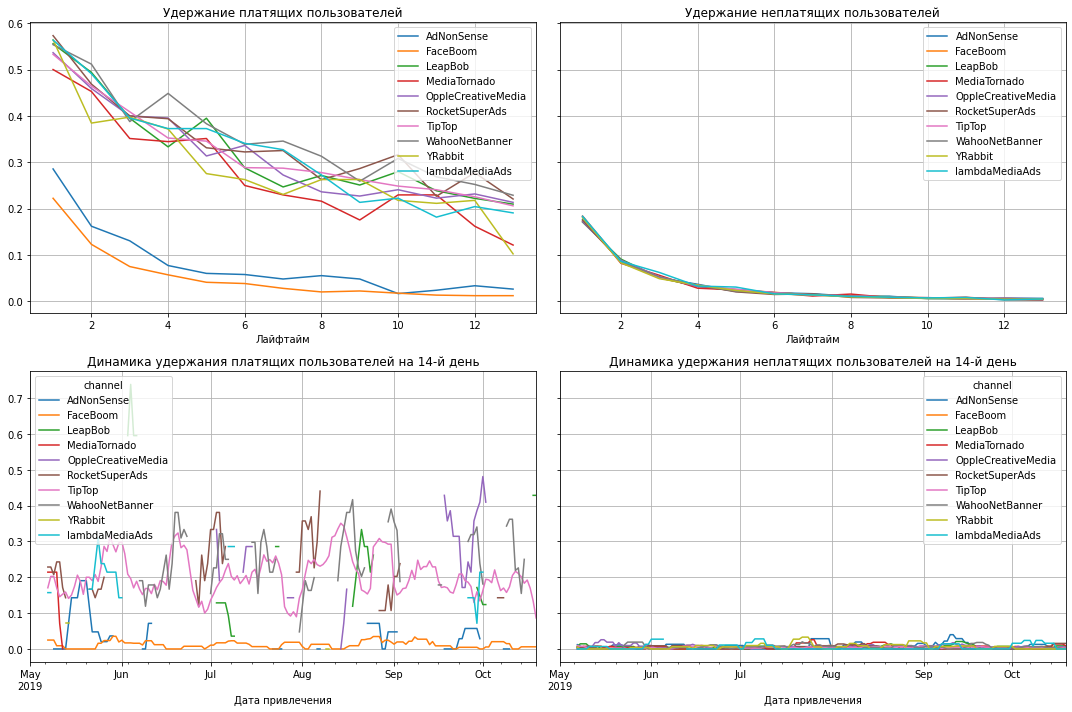

In [35]:
# смотрим удержание с разбивкой по каналам
dimensions = ['channel']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Еще одна зацепка! Очень низкое удержание у пользователей с каналов `FaceBoom и AdNonSense`. У остальных каналах все в пределах нормы.
<br>

## Анализ рекламных каналов `FaceBoom и TipTop`

In [36]:
# фильтрую платящих пользователей по USA
profiles2 = profiles.query('channel != "organic" and region == "United States"')

In [37]:
# смотрю таблицу распределение по всем каналам в США
report = profiles2.groupby('channel').agg({'user_id': 'nunique', 'payer': ['sum', 'mean']})
report.columns = ['Пользователи', 'Платящие пользователи', '% платящих']
report.sort_values(by = 'Пользователи', ascending = False).style.format({'Платящие пользователи': '{:.0f}', '% платящих': '{:.2%}'})

,Пользователи,Платящие пользователи,% платящих
channel,,,
FaceBoom,29144,3557,12.20%
TipTop,19561,1878,9.60%
RocketSuperAds,4448,352,7.91%
MediaTornado,4364,156,3.57%
YRabbit,4312,165,3.83%


Как и предпологалось, с `FaceBoom` и `TipTop` к нам приходит очень много пользователей.

In [38]:
# фильтрую платящих пользователей по USA по двум каналам
profiles2 = profiles.query('channel == "TipTop" or channel == "FaceBoom"')

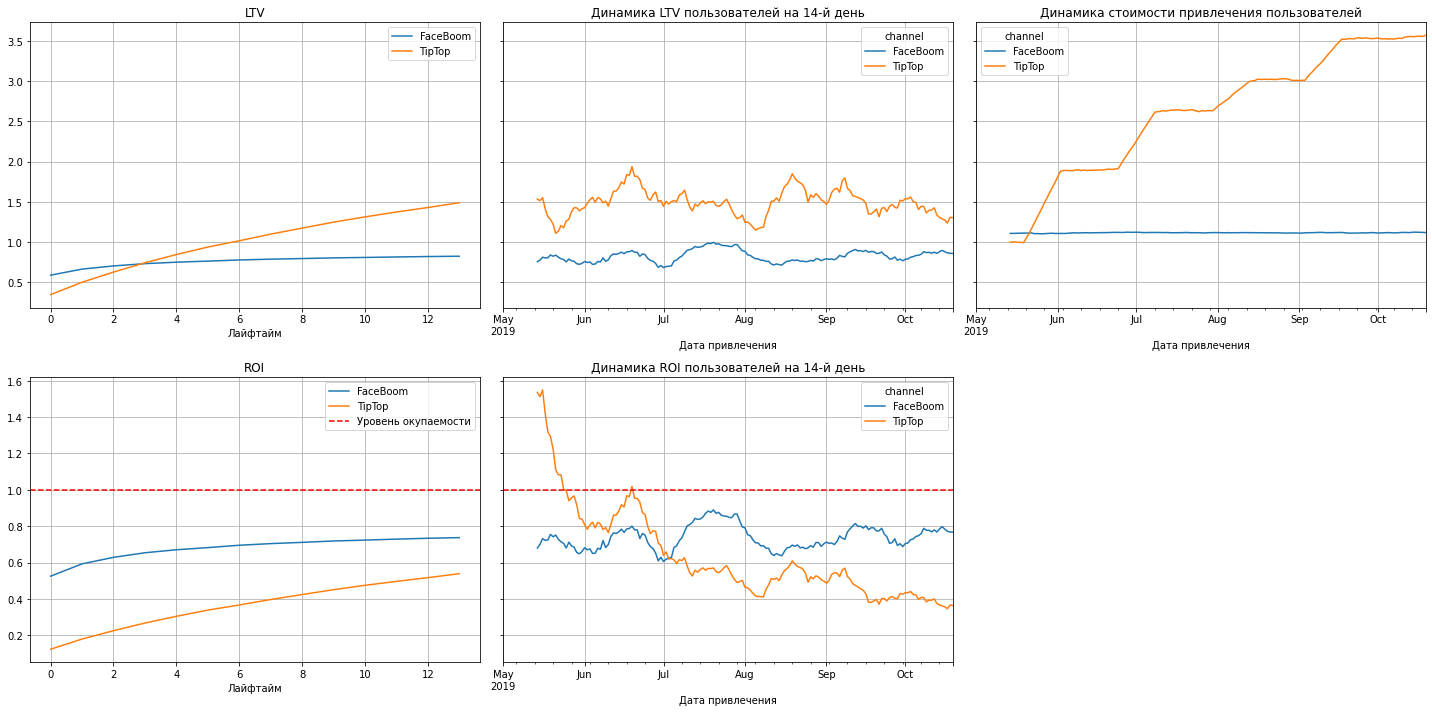

In [39]:
# анализ окупаемости двух каналов
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles2, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

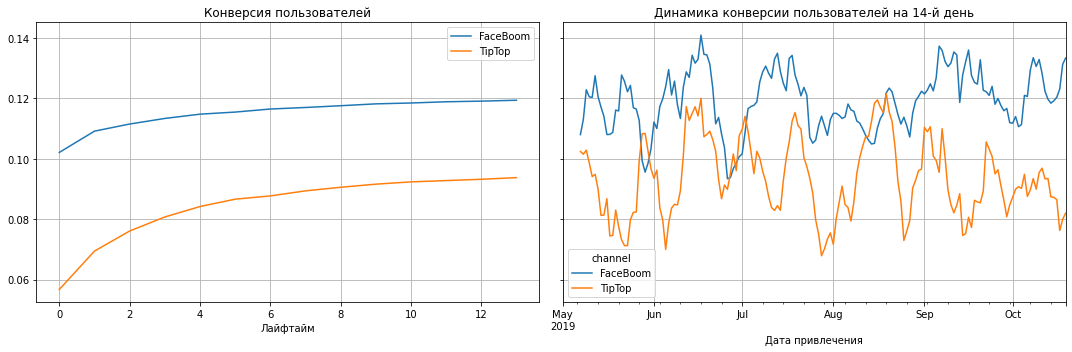

In [40]:
# анализ конверсии двух каналов
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles2, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

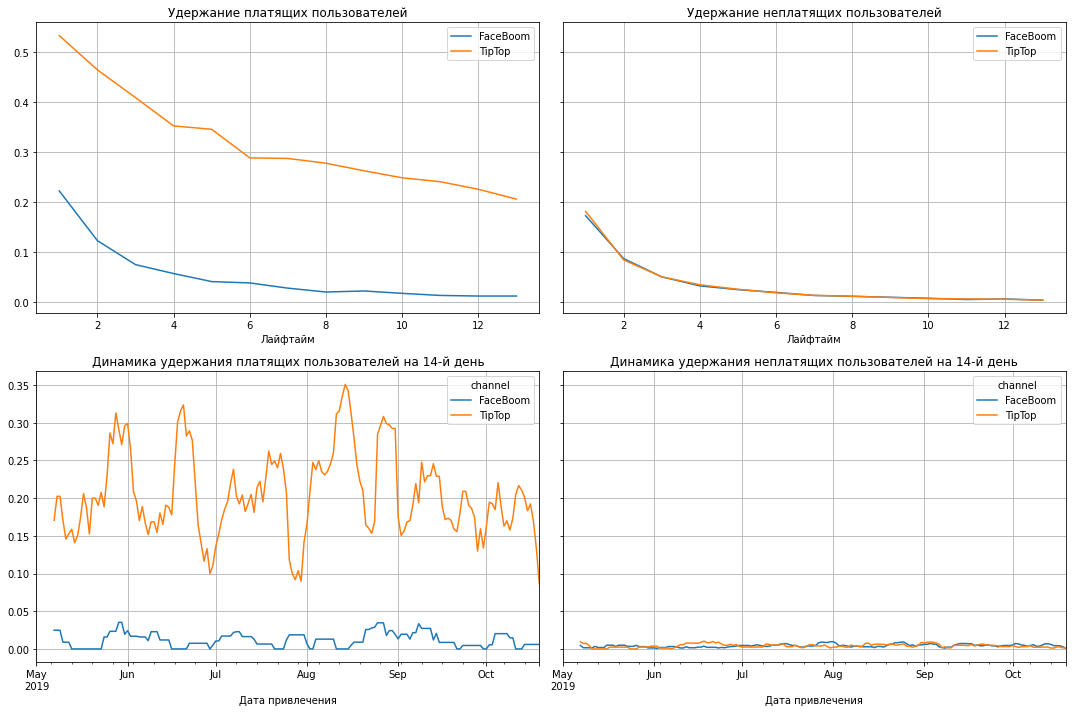

In [41]:
# анализ удержания двух каналов
retention_raw, retention_grouped, retention_history = get_retention(
    profiles2, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

## Вывод

Сейчас реклама не окупается из-за причин:
1. Слишком высокая стоимость закупки у канала `TipTop`.
2. Очень низкое удержание пользователей с каналов `FaceBoom и AdNonSense`. Причем оно падает со временем к нулю примерно на 10 день (т.е. там нет например технич. ошибок), возможно пользователям с этого канала не очень интересно наше приложение. Хотя конверсия у них очень хорошая, видимо пользователи заходят в приложение, совершают покупку и сразу отваливаются.

Рекомендации:<br>
1. Исключить из закупки каналы `TipTop, FaceBoom, AdNonSense`. (TipTop хорошо приносит и конверсия хорошая, но вот стоимость привлечения пользователей у него слишком высокая).
<br>
2. Увеличить закупки с каналов `YRabbit, MediaTornado, lambdaMediaAds, RocketSuperAds` (т.к. они самые лучше по окупаемости, и по остальным метрикам у них все хорошо).